In [3]:
import cv2
import numpy as np
# To solve the problem of the icons with relative path
import os
os.chdir(os.path.dirname(os.path.abspath(__file__)))

def moravec_corner_detection(image, threshold):
    """
    Detect corners in an image using the Moravec corner detection algorithm.

    Args:
    - image: Input grayscale image.
    - threshold: Threshold for corner detection. Pixels with a difference greater than this threshold are considered corners.

    Returns:
    - output_img: Image with detected corners highlighted in green.
    """

    # Convert input image to RGB format for visualization
    output_img = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)

    # Define shifts for neighboring pixels
    xy_shifts = [(1, 0), (1, 1), (0, 1), (-1, 1)]

    # Iterate over each pixel in the image
    for y in range(1, image.shape[0]-1):
        for x in range(1, image.shape[1]-1):
            # Initialize the variable E to a large value. It serves as a placeholder for the minimum difference
            # in intensity between the current pixel and its neighbors during the Moravec corner detection algorithm.
            E = 100000

            # Iterate over each neighboring pixel shift
            for shift in xy_shifts:
                # Compute the difference in intensity between the current pixel and its neighbor
                diff = int(image[y + shift[1], x + shift[0]]) - int(image[y, x])
                diff = diff * diff

                # Update E with the minimum difference found so far
                if diff < E:
                    E = diff
            
            # If the minimum difference (E) is above the threshold, mark the pixel as a corner
            if E > threshold:
                # Draw a green circle around the detected corner
                cv2.circle(output_img, (x, y), 5, (0, 255, 0), -1)
    
    return output_img

# Load input image
image = cv2.imread("Harris-Corner-600x570.jpg", cv2.IMREAD_GRAYSCALE)

# Set threshold for corner detection
threshold = 1000

# Perform Moravec corner detection
corners = moravec_corner_detection(image, threshold)

# Display the detected corners
cv2.imshow('Moravec Corner Detection', corners)
cv2.waitKey(0)
cv2.destroyAllWindows()


The correct lambda minus

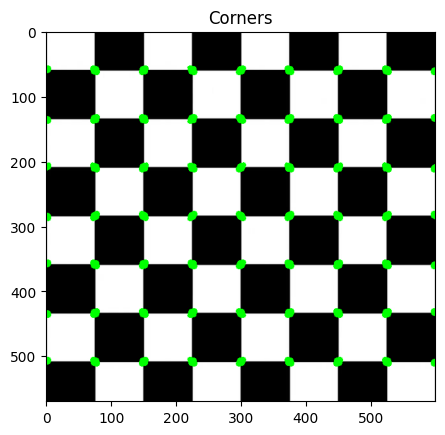

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in color mode
image = cv2.imread("Harris-Corner-600x570.jpg", cv2.IMREAD_COLOR)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute the gradient using Sobel operator
gradient_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
gradient_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

# Compute the elements of the H matrix
H_xx = gradient_x * gradient_x
H_yy = gradient_y * gradient_y
H_xy = gradient_x * gradient_y

# Compute the sum of the elements in a neighborhood (e.g., using a Gaussian kernel)
H_xx_sum = cv2.GaussianBlur(H_xx, (5, 5), 0)
H_yy_sum = cv2.GaussianBlur(H_yy, (5, 5), 0)
H_xy_sum = cv2.GaussianBlur(H_xy, (5, 5), 0)

# Compute the eigenvalues
eigenvalues = np.zeros_like(gray, dtype=np.float32)
for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
        H = np.array([[H_xx_sum[i, j], H_xy_sum[i, j]], [H_xy_sum[i, j], H_yy_sum[i, j]]])
        eigenvalues[i, j] = np.linalg.eigvals(H).min()

# Threshold to find corners
threshold = 0.01 * eigenvalues.max()  # You can adjust this threshold
corners = np.where(eigenvalues > threshold)

# Draw circles at detected corners
for i, j in zip(*corners):
    cv2.circle(image, (j, i), 3, (0, 255, 0), -1)  # Green color

# Display the result
# Display the result
plt.imshow(image)
plt.title('Corners')
plt.show()


In [10]:
def padding_matrix(matrix, width, height, pad_size):
    """
    Description:
        - Pad the input matrix with zeros from the four direction with the specified padding size.

    Parameters:
        - matrix (numpy.ndarray): The input matrix.
        - width (int): The desired width of the padded matrix.
        - height (int): The desired height of the padded matrix.
        - pad_size (int): The size of padding to add around the matrix.

    Returns:
        numpy.ndarray: The padded matrix.
    """
    padded_matrix = np.zeros((height + 2 * pad_size, width + 2 * pad_size)) # zeros matrix 
    padded_matrix[pad_size:pad_size+height, pad_size:pad_size+width] = matrix  
    return padded_matrix

def convolve2d_optimized(input_matrix, convolution_kernel, mode='same'):
    """
    Perform a 2D convolution of an input matrix with a convolution kernel.

    Parameters:
    - input_matrix (numpy.ndarray): The input matrix to be convolved.
    - convolution_kernel (numpy.ndarray): The kernel used for the convolution.
    - mode (str): The mode of convolution, can be 'same' (default), 'valid', or 'full'.

    Returns:
    - output_matrix (numpy.ndarray): The result of the convolution.
    """

    # Get dimensions of input matrix and kernel
    input_height, input_width = input_matrix.shape
    kernel_size = convolution_kernel.shape[0]
    padding_size = kernel_size // 2

    # Pad the input matrix
    padded_matrix = padding_matrix(input_matrix, input_width, input_height, pad_size=padding_size)

    # Create an array of offsets for convolution
    offset_array = np.arange(-padding_size, padding_size + 1)

    # Create a meshgrid of indices for convolution
    x_indices, y_indices = np.meshgrid(offset_array, offset_array, indexing='ij')

    # Add the meshgrid indices to an array of the original indices
    i_indices = np.arange(padding_size, input_height + padding_size)[:, None, None] + x_indices.flatten()
    j_indices = np.arange(padding_size, input_width + padding_size)[None, :, None] + y_indices.flatten()

    # Use advanced indexing to get the regions for convolution
    convolution_regions = padded_matrix[i_indices, j_indices].reshape(input_height, input_width, kernel_size, kernel_size)

    # Compute the convolution by multiplying the regions with the kernel and summing the results
    output_matrix = np.sum(convolution_regions * convolution_kernel, axis=(2, 3))

    return output_matrix

In [32]:
def compute_gradient_using_convolution(matrix, x_kernel, y_kernel):
        x_component = convolve2d_optimized(matrix,x_kernel, mode='same')
        y_component = convolve2d_optimized(image, y_kernel, mode='same')
        resultant = np.abs(x_component) + abs(y_component)
        resultant = resultant / np.max(resultant) * 255
        direction = np.arctan2(y_component, x_component) 
        return resultant

In [30]:
K_X = np.array([[-1, -2, 0, 2, 1],
                [-2, -3, 0, 3, 2],
                [-3, -5, 0, 5, 3],
                [-2, -3, 0, 3, 2],
                [-1, -2, 0, 2, 1]])

K_Y = K_X.T  # The kernel for vertical edges is the transpose of the kernel for horizontal edges

gradient_x_us, gradient_y_us = compute_gradient_using_convolution(gray, K_X, K_Y)

gradient_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
print(np.allclose(gradient_x, gradient_x_us, atol = 1000))


False


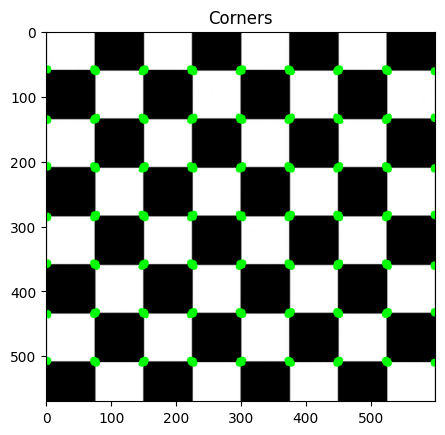

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in color mode
image = cv2.imread("Harris-Corner-600x570.jpg", cv2.IMREAD_COLOR)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute the gradient using Sobel 5x5 operator
K_X = np.array([[-1, -2, 0, 2, 1],
                [-2, -3, 0, 3, 2],
                [-3, -5, 0, 5, 3],
                [-2, -3, 0, 3, 2],
                [-1, -2, 0, 2, 1]])

K_Y = K_X.T  # The kernel for vertical edges is the transpose of the kernel for horizontal edges

gradient_x_us, gradient_y_us = convolve2d_optimized(gray, K_X, mode='same'),convolve2d_optimized(gray, K_Y, mode='same') 


# Compute the elements of the H matrix
H_xx = gradient_x * gradient_x
H_yy = gradient_y * gradient_y
H_xy = gradient_x * gradient_y

# Compute the sum of the elements in a neighborhood (e.g., using a Gaussian kernel)
# Define window function
window = np.ones((5, 5))
H_xx_sum = convolve2d_optimized(H_xx, window, mode='same')/25
H_yy_sum = convolve2d_optimized(H_yy, window, mode='same')/25
H_xy_sum = convolve2d_optimized(H_xy, window, mode='same')/25

# Compute the eigenvalues
H = np.stack([H_xx_sum, H_xy_sum, H_xy_sum, H_yy_sum], axis=-1).reshape(-1, 2, 2)
eigenvalues = np.linalg.eigvalsh(H).min(axis=-1).reshape(gray.shape)

# Threshold to find corners
threshold = 0.01 * eigenvalues.max() # You can adjust this threshold
corners = np.where(eigenvalues > threshold)

# Draw circles at detected corners by unpacking the corner object, drawing at each corner and then restoring its original combact state
for i, j in zip(*corners):
    cv2.circle(image, (j, i), 3, (0, 255, 0), -1)  # Green color

# Display the result
plt.imshow(image)
plt.title('Corners')
plt.show()


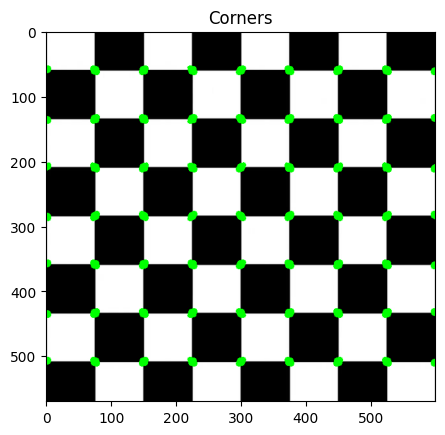

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in color mode
image = cv2.imread("Harris-Corner-600x570.jpg", cv2.IMREAD_COLOR)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute the gradient using Sobel operator
gradient_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
gradient_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

# Compute the elements of the H matrix
H_xx = gradient_x * gradient_x
H_yy = gradient_y * gradient_y
H_xy = gradient_x * gradient_y

# Compute the sum of the elements in a neighborhood (e.g., using a Gaussian kernel)
H_xx_sum = cv2.GaussianBlur(H_xx, (5, 5), 0)
H_yy_sum = cv2.GaussianBlur(H_yy, (5, 5), 0)
H_xy_sum = cv2.GaussianBlur(H_xy, (5, 5), 0)

# Compute the eigenvalues
H = np.stack([H_xx_sum, H_xy_sum, H_xy_sum, H_yy_sum], axis=-1).reshape(-1, 2, 2)
eigenvalues = np.linalg.eigvalsh(H).min(axis=-1).reshape(gray.shape)

# Threshold to find corners
threshold = 0.01 * eigenvalues.max()  # You can adjust this threshold
corners = np.where(eigenvalues > threshold)

# Draw circles at detected corners
for i, j in zip(*corners):
    cv2.circle(image, (j, i), 3, (0, 255, 0), -1)  # Green color

# Display the result
plt.imshow(image)
plt.title('Corners')
plt.show()
